<a href="https://colab.research.google.com/github/SMTorg/smt/blob/master/tutorial/SMT_MixedInteger_Engineering_applications.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div class="jumbotron text-left"><b>
    
This tutorial describes how to perform a mixed optimization using the SMT toolbox for engineering applications.
<div>
    
    May 2023 - version SMT 2.0 
  
    Paul Saves and Raul Carreira Rufato and Joseph Morlier

<div class="alert alert-info fade in" id="d110">
<p>Some updates</p>
<ol> -  EGO applied to mixed integer problems (1D, 2D and 4D) using continuous relaxation </ol>
<ol> -  Manipulation of mixed integer DOE </ol>
<ol> -  Gower distance to build surrogate model  of mixed integer functions (2D and 4D) </ol>    
<ol> -  EGO applied to mixed integer problems (4D) using Gower distance </ol>
<ol> -  EGO applied to mixed integer problems using Homoscedastic or  Heteroscedastic kernel </ol>   
</div>

<p class="alert alert-success" style="padding:1em">
To use SMT models, please follow this link : https://github.com/SMTorg/SMT/blob/master/README.md. The documentation is available here: http://smt.readthedocs.io/en/latest/
</p>

The reference paper is available 
here https://www.sciencedirect.com/science/article/pii/S0965997818309360?via%3Dihub 

or as a preprint: http://mdolab.engin.umich.edu/content/python-surrogate-modeling-framework-derivatives

For mixed integer with continuous relaxation, the reference paper is available here https://www.sciencedirect.com/science/article/pii/S0925231219315619

In [3]:
#to install smt
!pip install ConfigSpace
!pip install numba
!pip install smt



[notice] A new release of pip is available: 22.0.4 -> 23.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 22.0.4 -> 23.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 22.0.4 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [4]:
%matplotlib inline  

from math import exp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import norm
from scipy.optimize import minimize
import scipy
import six
from smt.applications import EGO
from smt.surrogate_models import KRG
from smt.sampling_methods import FullFactorial
from smt.sampling_methods import LHS
from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel
import matplotlib.font_manager
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler

from smt.surrogate_models import MixIntKernelType
from smt.applications.mixed_integer import MixedIntegerKrigingModel, MixedIntegerSurrogateModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from scipy.optimize import curve_fit
from sklearn.preprocessing import StandardScaler

#to ignore warning messages
import warnings
warnings.filterwarnings("ignore")

from smt.applications.mixed_integer import MixedIntegerSamplingMethod


from smt.utils.design_space import (
    DesignSpace,
    FloatVariable,
    IntegerVariable,
    OrdinalVariable,
    CategoricalVariable,
)


Definition of the plot function 

# Modeling a 4D structural problem

__Background__: Hybrid composite problem involves the integration of different types of composite materials in a structural or functional application. Composites are materials made from two or more distinct constituents with different properties, combined to achieve enhanced performance. In a hybrid composite problem, the challenge lies in optimizing the combination of materials, such as fiber-reinforced polymers, metal matrix composites, or ceramic matrix composites, to achieve specific desired characteristics, such as strength, weight reduction, or thermal resistance. 


The database is available at https://www.sciencedirect.com/science/article/abs/pii/S1359835X11000224

The aim is to build a surrogate model for mixed variables in a hybrid composite problem. The trained surrogate model is able to predict the composites characteristics. 
This is a tutorial for the following paper: A mixed-categorical data-driven approach for prediction and
optimization of hybrid discontinuous composites performance. 

The function inputs are:



> 4 continuous variables  **[lf Vc SmAvg G GiicmAvg]**


> 2 categorical variables **[Carbon fibres Glass Fibres]** with 16 levels.


The possible outputs are **[Initial_stiffness	Ultimate_strain	Pseudo_ductile_strain	Ultimate_strength	Yield_strength]**

In this example, only the most influent continuous inputs are being used (**lf** and **Vc**), and the predicted variable is the **Initial Stiffness**

**lf:** length of the fibre. 

**Vc:** Percentage of carbon fibre in the mixture. 

In [ ]:
plt.rcParams.update({'legend.labelspacing':1.0})

In [ ]:
try :
    from pydrive.auth import GoogleAuth
    from pydrive.drive import GoogleDrive
    from google.colab import auth
    from oauth2client.client import GoogleCredentials

    # 1. Authenticate and create the PyDrive client.
    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    drive = GoogleDrive(gauth)
    json_import = drive.CreateFile({'id':'1fcB39mktJ2npTNqrF8dgZa7PWh3wU55X'})
    json_import.GetContentFile('VTF_properties.json')
    df = pd.read_csv(open('VTF_properties.json'))
except :
    df = pd.read_csv(open('composite_material.csv'))

In [ ]:
df = df.dropna()
df.head()

In [ ]:
data = df.sample(n=1000,random_state = 10)
data.Carbon_fibre = pd.Categorical(data.Carbon_fibre)
data['Carbon_fibre'] = data.Carbon_fibre.cat.codes  
data.Glass_fibre = pd.Categorical(data.Glass_fibre)
data['Glass_fibre'] = data.Glass_fibre.cat.codes  
Xd = data.drop(['SmAvg','G','GiicmAvg','Initial_stiffness','Ultimate_strain','Pseudo_ductile_strain','Ultimate_strength',
             'Yield_strength'],axis = 1)

yd = data.Initial_stiffness

X_train, X_test, y_train, y_test = train_test_split(Xd, yd, test_size = 0.25, random_state = 42)
X = np.asarray(X_train)
y = np.asarray(y_train).astype(float)

#to define the variables
design_space = DesignSpace ([
    CategoricalVariable (['XN-90', 'P120J', 'T1000GB', 'C124', 'T800H', 'M60JB', 'C320',
       'M40B', 'P75S', 'K13D', 'T300', 'XN-05', 'FliteStrand_S_ZT',
       'HTA5131', 'GF', 'C100']), #16 choices
     CategoricalVariable (['GF', 'XN-05', 'FliteStrand_S_ZT', 'C124', 'T300', 'T800H', 'C320',
       'P75S', 'C100', 'XN-90', 'HTA5131', 'T1000GB', 'P120J', 'M40B',
       'M60JB']), #15 choices
    FloatVariable (501.5425023,11999.96175),
    FloatVariable (2.849e-05,1.0),
])


In [ ]:
sm=KRG(design_space = design_space, print_global=False, categorical_kernel=MixIntKernelType.GOWER)
sm.set_training_values(X, y)
sm.train()

In [ ]:
y_pred2 =sm.predict_values(np.asarray(X_test))
y_pred2[y_pred2<0]=0

print("r2_score = ", r2_score(y_test, y_pred2))

plt.scatter(y_test, y_pred2, s=30, facecolors='none', edgecolors='r')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Initial_stiffness')
plt.axis('equal')
plt.axis('square')
plt.grid()
_ = plt.plot([-500000, 500000], [-500000, 500000],'b')

# Modeling a complex system

__Background__: Lithium-ion batteries are commonly used for portable electronics, electric vehicles, and aerospace applications. During discharge, Lithium ions move from the negative electrode through an electrolyte to the positive electrode to create a voltage and current. During recharging, the ions migrate back to the negative electrode. The crystal structure (monoclinic, orthorhombic, triclinic) is available for 339 different chemicals that contain Li-ion.

The database is available at [Lithium-ion Chemical Properties and Crystal Structure Data](https://apmonitor.com/pds/uploads/Main/lithium_ion.txt)


__Objective__: Predict the crystal structure type (monoclinic, orthorhombic, triclinic) from Lithium-ion physical and chemical compound information.

This tutorial covers the following:
- Categorical transformation techniques
- Feature creation
- Feature selection


The function inputs are:

>  5 continuous variables  **[Formation Energy (eV) 	E Above Hull (eV) 	Band Gap (eV) 	Nsites 	Density (gm/cc) 	Volume]**

>  1 ordinal variable  **[Nsites]**

> 4 categorical variables **[Materials Id 	Formula 	Spacegroup 	Has Bandstructure]** with respectively: 339, 114 and 44 levels.


The relaxed dimension by one-hot-encoding is  503
# => REALLY HIGH CATEGORICAL DIMENSION

In [13]:
try:
    import chemparse
    import smt
except:
    !pip install chemparse
    print('May need to restart kernel to use chemparse')
# Import libraries and data
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import FeatureHasher
from sklearn.metrics import confusion_matrix,plot_confusion_matrix

from sklearn.datasets import make_circles, make_classification, make_moons
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from smt.utils.design_space import  FloatVariable, IntegerVariable, OrdinalVariable,CategoricalVariable
import pandas as pd 
import numpy as np
from smt.applications.mixed_integer import (
    MixedIntegerContext,
    MixedIntegerSamplingMethod,
    MixedIntegerKrigingModel
)
from smt.surrogate_models import (
    KRG,
    GEKPLS,
    KPLS,
    QP,
    MixIntKernelType,
    MixHrcKernelType,
)
# Load and display data
url = 'http://apmonitor.com/pds/uploads/Main/lithium_ion.txt'
data = pd.read_csv(url)
datatype = data.dtypes
data.head()

,Materials Id,Formula,Spacegroup,Formation Energy (eV),E Above Hull (eV),Band Gap (eV),Nsites,Density (gm/cc),Volume,Has Bandstructure,Crystal System
0,mp-849394,Li2MnSiO4,Pc,-2.699,0.006,3.462,16,2.993,178.513,True,monoclinic
1,mp-783909,Li2MnSiO4,P21/c,-2.696,0.008,2.879,32,2.926,365.272,True,monoclinic
2,mp-761311,Li4MnSi2O7,Cc,-2.775,0.012,3.653,28,2.761,301.775,True,monoclinic
3,mp-761598,Li4Mn2Si3O10,C2/c,-2.783,0.013,3.015,38,2.908,436.183,True,monoclinic
4,mp-767709,Li2Mn3Si3O10,C2/c,-2.747,0.016,2.578,36,3.334,421.286,True,monoclinic


In [ ]:
indy = 10 #Crystal
design_space_battery = []
catlists=[]
for indi,i in enumerate(datatype) : 
    if indi != 8 :
        if i == "object" or i == "bool" : 
            ilist =list(np.unique(np.array(data[data.columns[indi]]))) 
            if i == "object" : 
                catlists.append(ilist)
            design_space_battery.append(CategoricalVariable(ilist))
        elif i == "int64" : 
            ilist =list(np.unique(np.array(data[data.columns[indi]]))) 
            design_space_battery.append(IntegerVariable(min(ilist),max(ilist)))
        elif i == "float64" : 
            ilist =list(np.unique(np.array(data[data.columns[indi]]))) 
            design_space_battery.append(FloatVariable(min(ilist)-1e-9,max(ilist)+1e-9))

Training_data=data.sample(int(339*0.3),random_state=42)
Val_data = pd.concat([data,Training_data]).drop_duplicates(keep=False)
index_train = np.array(list(enumerate(Training_data.T))).T[1]
index_val = np.array(list(enumerate(Val_data.T))).T[1]


In [ ]:
# Separate into numerical features that don't need preprocessing, and categorical features that need to be transformed
num_feat = data.select_dtypes(include=['int64','float64']).columns
cat_feat = data.select_dtypes(include=['object','bool']).columns

In [ ]:
# Count elements to transform data to ordinal values
ord_feat = ['Formation Energy (eV)','E Above Hull (eV)','Band Gap (eV)',
            'Nsites','Density (gm/cc)','Volume','Has Bandstructure',
            'Spacegroup (ordinal)','Formula (#)' ]

hash_feat = ['Formation Energy (eV)','E Above Hull (eV)','Band Gap (eV)',
             'Nsites','Density (gm/cc)','Volume','Has Bandstructure',
             'Spacegroup0','Spacegroup1','Spacegroup2',
             'Formula (#)'
            ]

## USING A RANDOM FOREST CLASSIFIER

#### 1. Original Numerical features only
Method: Ignore categorical variables and treat only the continuous ones.

Pros: Simple and quick. We can use directly the continuous models

Cons: Lose a lot of information. 

#### 2. Encode to ordinal variables
Method: assign each unique value to a unique number. The categorical variables representative of molecules are separated by atom types to help.

Example: Spacegroup = Pc is assigned to 0, Spacegroup = P21/c is assigned to 1, etc. 

Pros: simple and quick, 1 column in -> 1 column out

Cons: residual "structure" (number assigned is arbitrary, and it leads algorithms to assume that a Spacegroup with a value of 20 is higher value than a Spacegroup of value 1)

#### 3. Feature Hashing
Method: Encode each unique category into a non-binary vector. The categorical variables representative of molecules are separated by atom types to help.

Example: Spacegroup = Pc is assigned to [1,0,0], Spacegroup = P21/c is assigned to [1,2,-1], etc. Specify number of columns (length of vector)

Pros: low dimensionality so really efficient.

Cons: potential collisions (for example the 1st value in example has both Spacegroups sharing a '1'); hashed features aren't interpretable so can't be used in feature importance. 


In [ ]:
# Save new features in dataframe
data.to_csv('lithium_ion_data.csv',index=False)

# Option 2: Ordinal number encoding
data['Spacegroup (ordinal)'] = pd.factorize(data['Spacegroup'])[0]

# Can also order by most common to least common
data['Spacegroup'].rank(method="dense").astype(int)

# Option 2: Ordinal number encoding
data['Formula (#)'] = pd.factorize(data['Formula'])[0]



# Option 3: Feature Hashing
n = 3
fh = FeatureHasher(n_features=n, input_type='string')
hashed_tag = fh.fit_transform(data['Spacegroup']).toarray()
ht_df = pd.DataFrame(hashed_tag)
ht_df.columns = ['Spacegroup'+str(i) for i in range(n)]

data = data.join(ht_df)
# Encode Crystal System to ordinal values for multi-class problem
labelencoder = LabelEncoder() #initializing an object of class LabelEncoder
data['Crystal System (#)'] = labelencoder.fit_transform(data['Crystal System']) 


# For a multi-label problem, use one-hot encoding
data[['monoclinic','orthorhombic','triclinic']] = pd.get_dummies(data['Crystal System'])

In [ ]:
# All new numerical features (Crystal System excluded, since it's int32)
features = list(data.select_dtypes(include=['int64','float64']).columns.values)

ord_feat = ['Formation Energy (eV)','E Above Hull (eV)','Band Gap (eV)',
            'Nsites','Density (gm/cc)','Volume','Has Bandstructure',
            'Spacegroup (ordinal)','Formula (#)'
           ]

hash_feat = ['Formation Energy (eV)','E Above Hull (eV)','Band Gap (eV)',
             'Nsites','Density (gm/cc)','Volume','Has Bandstructure',
             'Spacegroup0','Spacegroup1','Spacegroup2',
             'Formula (#)'
            ]

labels = ['Crystal System (#)']

plt.figure(figsize=(16,5))

titles = ['Original Numerical Features Only',
          'With Encoded Features\n(Ordinal Spacegroup)',
          'With Encoded Features\n(Hashed Spacegroup)'
         ]

for i, feat in enumerate([num_feat,ord_feat,hash_feat]):
    X = data[feat]
    y = data[labels]

    # 80% training data and 20% testing
    Xtrain = X.iloc[list(index_train)]
    Xtest = X.iloc[list(index_val)]
    ytrain = y.iloc[list(index_train)]
    ytest = y.iloc[list(index_val)]
    
    dtree = RandomForestClassifier( max_depth=5, n_estimators=10, max_features=1, random_state=42)
    dtree.fit(Xtrain,ytrain)
    yp = dtree.predict(Xtest)
    
    # Plot confusion matrix
    plt.subplot(1,3,i+1)
    cm = confusion_matrix(ytest,yp)
    sns.heatmap(cm,annot=True)
    plt.title(titles[i])

#### 4. Mixed integer Kriging by Continuous relaxation and Gower distance
Method: Build a mixed integer Kriging model for prediction based on Gower distance.

Pros: Simple to use thanks to SMT. Fast to build. No need to treat the data (black-box). Perfect predictions.

Cons: None

In [ ]:
Feat = ['Materials Id','Formula', 'Spacegroup', 'Formation Energy (eV)', 'E Above Hull (eV)', 'Band Gap (eV)', 'Nsites', 'Density (gm/cc)', 'Volume', 'Has Bandstructure']
data= data[Feat]

In [ ]:
Ydata = Training_data[Training_data.columns[indy]]
Yt = np.array(Ydata)
Yt2 = np.copy(Yt)
indi=0
for yt in Yt :
    if yt =="triclinic" :
        Yt2[indi] = 2
    elif yt =="orthorhombic" :
        Yt2[indi] = 1
    elif yt =="monoclinic" :
        Yt2[indi] = 0
    indi = indi+1
Yt = Yt2
Yt=Yt.astype(float)

Training_data.drop(Training_data.columns[indy], axis=1, inplace=True)
Xtd=np.array(Training_data)
Xt = np.copy(Xtd)
indcat=-1
for i in range(np.shape(Xtd)[1]) : 
    if type(Xtd[0,i]) == str :
        indcat = indcat+1
        for j in range(np.shape(Xtd)[0]) :
            Xt[j,i]=np.float64(catlists[indcat].index(Xtd[j,i]))
    elif type(Xtd[0,i]) == bool :
        for j in range(np.shape(Xtd)[0]) :
            if Xtd[j,i] ==True :
                Xt[j,i]=1
            else : 
                Xt[j,i] = 0
    else : 
        for j in range(np.shape(Xtd)[0]) :
            Xt[j,i]=np.float64(Xtd[j,i])
Xt=Xt.astype(float)


sm = MixedIntegerKrigingModel (
     surrogate =KRG( design_space = design_space_battery, 
     categorical_kernel = MixIntKernelType.GOWER,
     theta0=[1e-2],
     corr="squar_exp",
     n_start=30,
     ))
sm.set_training_values (Xt , Yt)
sm.train()

Yvalid = np.array(Val_data[Val_data.columns[indy]])
Yt2 = np.copy(Yvalid)
indi=0
for yt in Yvalid :
    if yt =="triclinic" :
        Yt2[indi] = 2
    elif yt =="orthorhombic" :
        Yt2[indi] = 1
    elif yt =="monoclinic" :
        Yt2[indi] = 0
    indi = indi+1
Yvalid = Yt2
Yvalid=Yvalid.astype(float)

Val_data.drop(Val_data.columns[indy], axis=1, inplace=True)
Xtv=np.array(Val_data)

Xvalid = np.copy(Xtv)
indcat=-1
for i in range(np.shape(Xtv)[1]) : 
    if type(Xtv[0,i]) == str :
        indcat = indcat+1
        for j in range(np.shape(Xtv)[0]) :
            Xvalid[j,i]=np.float64(catlists[indcat].index(Xtv[j,i]))
    elif type(Xtv[0,i]) == bool :
        for j in range(np.shape(Xtv)[0]) :
            if Xtv[j,i] ==True :
                Xvalid[j,i]=1
            else : 
                Xvalid[j,i] = 0
    else : 
        for j in range(np.shape(Xtd)[0]) :
            Xvalid[j,i]=np.float64(Xtv[j,i])
Xvalid=Xvalid.astype(float)

plt.figure()
cm = confusion_matrix(np.atleast_2d(np.abs(np.around(sm.predict_values(Xvalid).T,0)))[0],Yvalid)
sns.heatmap(cm,annot=True)
plt.plot()

# Additive Manufacturing

Additive manufacturing is the process of building from a computer controlled 3-dimensional printer. The material can be polymer (plastic), ceramic, metallic powder, liquid, or any material that is joined together through deposition, solidification, or fusion. It speeds the development of prototypes by precisely converting a computer aided design (CAD) drawing into a physical device. Additive manufacturing can be either a prototype or scaled up to full product production, but typically for applications that require customization or with low production volumes.

Background: A 3D print data set of additive manufacturing test conditions is available for Polylactic Acid (PLA) and Acrylonitrile Butadiene Styrene (ABS). PLA can print at lower temperatures of 180°C compared to 250°C for ABS. PLA is more brittle than ABS and is not typically suitable for high strength applications. The data was collected by researchers in the Mechanical Engineering department at Selçuk Üniversitesi on a Ultimaker S5 3D printer. The study focused on how the parameters in a specific 3D printer affects the print quality, accuracy and final part strength. This work is based on the settings and PLA or ABS filaments. Material and strength tests were carried out on a Sincotec GMBH tester capable of pulling 20 kN.
Nine parameters were adjusted for the Ultimaker S5 3D printer.


*   Layer Height (mm)
*   Wall Thickness (mm)
*   Infill Density (%)
*   Infill Pattern (Honeycomb or Grid)
*   Nozzle Temperature (ºC)
*   Bed Temperature (ºC)
*   Print Speed (mm/s)
*   Material (PLA or ABS)
*   Fan Speed (%)
*   After the part was manufactured, three parameters were measured for each product.
*   Roughness (µm)
*   Tension Strength (MPa)
*   Elongation (%)



The labeled data is a combination of PLA and ABS material, print patterns, and conditions with 66 samples from a first repository and 50 samples from a second repository. The combined set is 70 samples with the duplicates removed and one outlier added. The label associated with each filament is pla or abs. The print pattern is grid or honeycomb. One-hot encoding translates character labels into a binary representation (0 or 1) for classification.

In [5]:
# Load data from URL
url = "https://apmonitor.com/pds/uploads/Main/manufacturing.txt"
data = pd.read_table(url, delimiter=',')

# Change and store variable names
parameters = ["Layer Height", "Wall Thickness", "Infill Density",
              "Infill Pattern", "Nozzle Temperature", "Bed Temperature",
              "Print Speed", "Material", "Fan Speed",
              "Roughness", "Tension Strength", "Elongation"]
data.columns = parameters

data.head()

,Layer Height,Wall Thickness,Infill Density,Infill Pattern,Nozzle Temperature,Bed Temperature,Print Speed,Material,Fan Speed,Roughness,Tension Strength,Elongation
0,0.02,8.0,90,grid,220,60,40,abs,0,25,18,1.2
1,0.02,7.0,90,honeycomb,225,65,40,abs,25,32,16,1.4
2,0.02,1.0,80,grid,230,70,40,abs,50,40,8,0.8
3,0.02,4.0,70,honeycomb,240,75,40,abs,75,68,10,0.5
4,0.02,6.0,90,grid,250,80,40,abs,100,92,5,0.7


In [6]:
# Save new features in dataframe
data.to_csv('additive_manufacturing.csv',index=False)


## 1. Surrogate Modeling Toolbox -> Kringing method with mixed variables

In [7]:
# Decode the data back to its original form
label_encoder_infill = LabelEncoder()
label_encoder_material = LabelEncoder()
data['Infill Pattern'] = label_encoder_infill.fit_transform(data['Infill Pattern'])
data['Material'] = label_encoder_material.fit_transform(data['Material'])
data.head()
X = data.drop('Tension Strength', axis=1)
y = data['Tension Strength']
#scaler = StandardScaler()
#X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
data['Infill Pattern'] = label_encoder_infill.inverse_transform(data['Infill Pattern'])
data['Material'] = label_encoder_material.inverse_transform(data['Material'])
data['Infill Pattern']= pd.Categorical(data['Infill Pattern'])
data['Infill Pattern'] = data['Infill Pattern'].cat.codes

data['Material']= pd.Categorical(data['Material'])
data['Material'] = data['Material'].cat.codes

X = data.drop('Tension Strength', axis=1)
y = data['Tension Strength']

# Identify the indices of the non-categorical columns
non_categorical_indices = [0,1,2,4,5,6,8,9,10]

# Extract the non-categorical features
X_non_categorical = X.iloc[:, non_categorical_indices]

# Apply StandardScaler only to the non-categorical features
#scaler = StandardScaler()
#X_non_categorical_scaled = scaler.fit_transform(X_non_categorical)

# Replace the non-categorical features in the original matrix with the scaled values
X.iloc[:, non_categorical_indices] = X_non_categorical
X_ = np.asarray(X)
y_ = np.asarray(y).astype(float)
X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size=0.3, random_state=42)
# Create the design space
design_space = DesignSpace(
    [
        FloatVariable (data["Layer Height"].min(),data["Layer Height"].max()), # Layer Height
        FloatVariable (data["Wall Thickness"].min(),data["Wall Thickness"].max()), # Wall Thickness
        FloatVariable (data["Infill Density"].min(),data["Infill Density"].max()), # Infill Density
        CategoricalVariable(list(label_encoder_infill.classes_)),  # Infill Pattern
        FloatVariable (data["Nozzle Temperature"].min(),data["Nozzle Temperature"].max()), # Nozzle Temperature
        FloatVariable (data["Bed Temperature"].min(),data["Bed Temperature"].max()), # Bed Temperature
        FloatVariable (data["Print Speed"].min(),data["Print Speed"].max()), # Layer Height
        CategoricalVariable(list(label_encoder_material.classes_) ),  # Material
        FloatVariable (data["Fan Speed"].min(),data["Fan Speed"].max()), # Fan Speed
        FloatVariable (data["Roughness"].min(),data["Roughness"].max()), # Roughness
        FloatVariable (data["Elongation"].min(),data["Elongation"].max()), # Layer Height
    ]
)

# Initialize the mixed-integer kriging model
sm=KRG(design_space = design_space, 
       corr="abs_exp",
       n_start=30,
       print_global=False,
       categorical_kernel=MixIntKernelType.HOMO_HSPHERE)
sm.set_training_values(X_train, np.atleast_2d(y_train).T)
sm.train()
# Predict on train and test sets
y_train_pred_smt = sm.predict_values(X_train).T[0]
y_test_pred_smt = sm.predict_values(X_test).T[0]

# Calculate R2 scores
r2_train_smt = r2_score(y_train, y_train_pred_smt)
r2_test_smt = r2_score(y_test, y_test_pred_smt)

## Data Preprocessing for continuous models

**Encode categorical variables (Infill Pattern and Material)**

In [9]:
label_encoder_infill = LabelEncoder()
label_encoder_material = LabelEncoder()
data['Infill Pattern'] = label_encoder_infill.fit_transform(data['Infill Pattern'])
data['Material'] = label_encoder_material.fit_transform(data['Material'])
data.head()
X = data.drop('Tension Strength', axis=1)
y = data['Tension Strength']
scaler = StandardScaler()
X = scaler.fit_transform(X)

## 2. Linear model

In [10]:
# Initialize the model
linear_model = LinearRegression()

# Fit the model
linear_model.fit(X_train, y_train)

# Predict on train and test sets
y_train_pred_linear = linear_model.predict(X_train)
y_test_pred_linear = linear_model.predict(X_test)

# Calculate R2 scores
r2_train_linear = r2_score(y_train, y_train_pred_linear)
r2_test_linear = r2_score(y_test, y_test_pred_linear)


## 3. Neural Network (Deep Learning)

In [11]:
# Initialize the model
nn_model = MLPRegressor(hidden_layer_sizes=(100,), max_iter=500)

# Fit the model
nn_model.fit(X_train, y_train)

# Predict on train and test sets
y_train_pred_nn = nn_model.predict(X_train)
y_test_pred_nn = nn_model.predict(X_test)

# Calculate R2 scores
r2_train_nn = r2_score(y_train, y_train_pred_nn)
r2_test_nn = r2_score(y_test, y_test_pred_nn)

## 4. Surrogate Modeling Toolbox -> KPLS with automatic number of component

In [14]:
# Initialize the model
sm_model_Q = KPLS(eval_n_comp=True,print_global = False)
sm_model_Q.set_training_values(np.array(X_train), np.array(y_train).reshape(-1,1))

# Fit the model
sm_model_Q.train()

# Predict on train and test sets
y_train_pred_KPLS = sm_model_Q.predict_values(np.array(X_train)).T[0] 
y_test_pred_KPLS = sm_model_Q.predict_values(np.array(X_test)).T[0]

# Calculate R2 scores
r2_train_KPLS = r2_score(y_train, y_train_pred_KPLS)
r2_test_KPLS = r2_score(y_test, y_test_pred_KPLS)

### Results 3D printing

In [15]:
# Print R2 scores for each model on train and test sets
print("Linear Regression:")
print(f"Train R2: {r2_train_linear:.4f}")
print(f"Test R2: {r2_test_linear:.4f}\n")

print("Neural Network:")
print(f"Train R2: {r2_train_nn:.4f}")
print(f"Test R2: {r2_test_nn:.4f}\n")

print("SMT KPLS cont:")
print(f"Train R2: {r2_train_KPLS:.4f}")
print(f"Test R2: {r2_test_KPLS:.4f}\n")

print("SMT KRG Mixed:")
print(f"Train R2: {r2_train_smt:.4f}")
print(f"Test R2: {r2_test_smt:.4f}\n")

Linear Regression:
Train R2: 0.8080
Test R2: 0.6566

Neural Network:
Train R2: -1.8152
Test R2: -1.9407

SMT KPLS cont:
Train R2: 1.0000
Test R2: 0.7156

SMT KRG Mixed:
Train R2: 1.0000
Test R2: 0.7592



#### Parity Plot
A parity plot is a scatter plot with predicted versus measured. A parity plot of the training and test data is a good way to see the overall fit of tension strength.

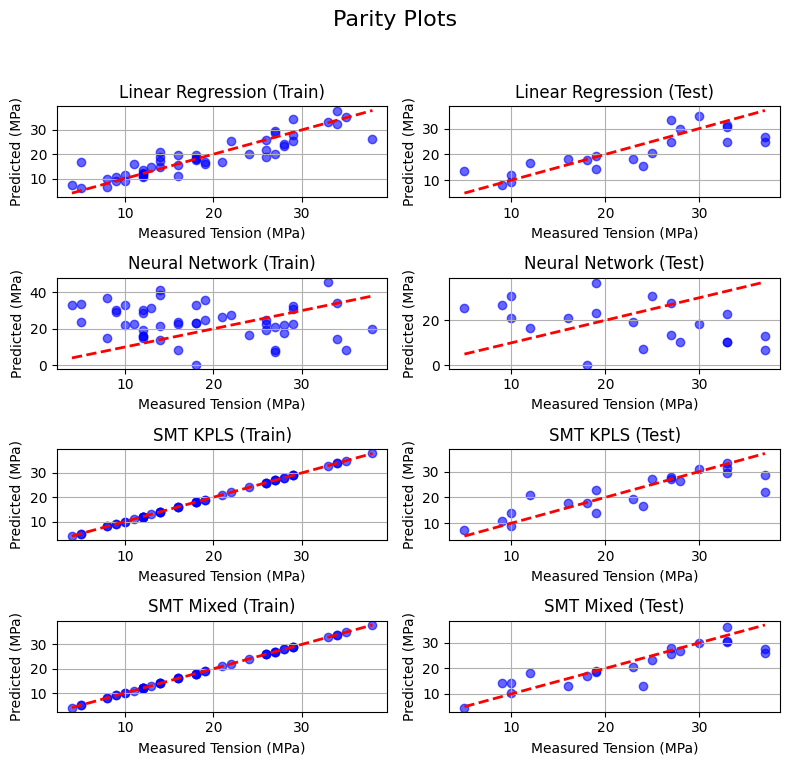

In [16]:
# Function to create a parity plot
def parity_plot(ax, y_true, y_pred, title):
    ax.scatter(y_true, y_pred, color='blue', alpha=0.6)
    ax.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], linestyle='--', color='red', linewidth=2)
    ax.set_title(title)
    ax.set_xlabel('Measured Tension (MPa)')
    ax.set_ylabel('Predicted (MPa)')
    ax.grid(True)

# Create subplots
fig, axs = plt.subplots(4, 2, figsize=(8, 8))
fig.suptitle('Parity Plots', fontsize=16)
# Parity plot for Linear Regression
parity_plot(axs[0, 0], y_train, y_train_pred_linear, 'Linear Regression (Train)')
parity_plot(axs[0, 1], y_test, y_test_pred_linear, 'Linear Regression (Test)')

# Parity plot for Neural Network
parity_plot(axs[1, 0], y_train, y_train_pred_nn, 'Neural Network (Train)')
parity_plot(axs[1, 1], y_test, y_test_pred_nn, 'Neural Network (Test)')

# Parity plot for SMT
parity_plot(axs[2, 0], y_train, y_train_pred_KPLS, 'SMT KPLS (Train)')
parity_plot(axs[2, 1], y_test, y_test_pred_KPLS, 'SMT KPLS (Test)')

# Parity plot for SMT
parity_plot(axs[3, 0], y_train, y_train_pred_smt, 'SMT Mixed (Train)')
parity_plot(axs[3, 1], y_test, y_test_pred_smt, 'SMT Mixed (Test)')

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()